# Plot image

Text(0.5, 1.0, 'undistorted image')

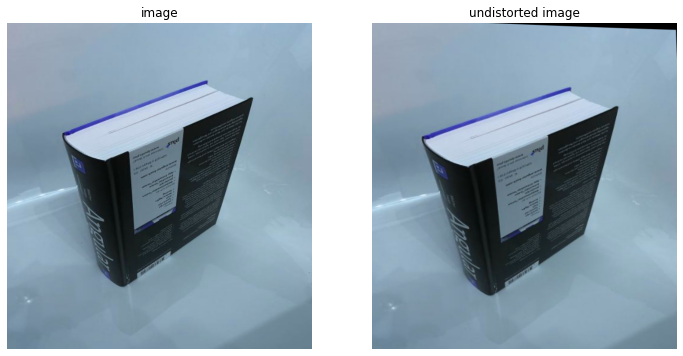

In [69]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

object_points, image_points, ret, k_matrix, distortion, r_vecs, t_vecs = np.load("Calibration/cam_parameters_iPhone8.npy", allow_pickle=True)

# Load the image and undistort it using the calibration parameters
imageName = 'images/book.JPG'
image = cv2.imread(imageName)
undistorted_image = cv2.undistort(image, k_matrix, distortion)

fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[0].imshow(image, aspect = 'auto')
axs[1].imshow(undistorted_image, aspect = "auto")
axs[0].set_title("image")
axs[1].set_title("undistorted image")

In [70]:
##Using undistorted image important? 
##if important insert:
#image = undistorted_image

# Hough line method for vanishing point detection
#### https://stackoverflow.com/questions/57535865/extract-vanishing-point-from-lines-with-open-cv

## Find parameters for good vanishing lines
#### defined varibles in this section, which are used later:  lines
#### https://stackoverflow.com/questions/21324950/how-can-i-select-the-best-set-of-parameters-in-the-canny-edge-detection-algorith

Text(0.5, 1.0, 'vanishing lines')

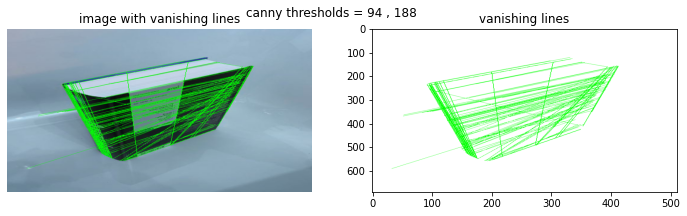

In [71]:
imageWithEdges = cv2.imread(imageName)
gray = cv2.cvtColor(imageWithEdges, cv2.COLOR_RGB2GRAY)
#find optimum parameters for canny (edge detection)
v = np.mean(gray)
sigma = 0.33
cannyTh1 = int(max(0, (1.0 - sigma) * v))
cannyTh2 = int(min(255, (1.0 + sigma) * v))
edges = cv2.Canny(gray, cannyTh1, cannyTh2)

lines = cv2.HoughLinesP(edges, 1, np.pi/180, 30, maxLineGap=2500)
whiteImage = np.full((imageWithEdges.shape[0],imageWithEdges.shape[1],imageWithEdges.shape[2]),255,dtype = np.uint8)

for line in lines:
  x1, y1, x2, y2 = line[0]
  cv2.line(imageWithEdges, (x1, y1), (x2, y2), (0, 255, 0), 1)
  cv2.line(whiteImage, (x1, y1), (x2, y2), (0, 255, 0), 1)
  
fig, axs = plt.subplots(1,2,figsize=(12,3))
fig.suptitle("canny thresholds = "+str(cannyTh1)+" , "+str(cannyTh2))
axs[0].set_axis_off()
axs[0].imshow(imageWithEdges, aspect = 'auto')
axs[1].imshow(whiteImage, aspect = "auto")
axs[0].set_title("image with vanishing lines")
axs[1].set_title("vanishing lines")

## Optimize vanishing lines

Text(0.5, 1.0, 'image with optimized vanishing lines')

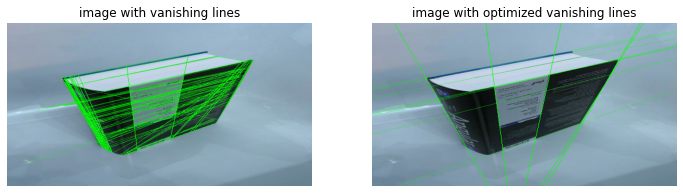

In [72]:
imageWithEdgesOptimized = cv2.imread(imageName)
gray = cv2.cvtColor(imageWithEdgesOptimized, cv2.COLOR_RGB2GRAY)
#find optimum parameters for canny (edge detection)
v = np.mean(gray)
sigma = 0.33
cannyTh1 = int(max(0, (1.0 - sigma) * v))
cannyTh2 = int(min(255, (1.0 + sigma) * v))
edges = cv2.Canny(gray, cannyTh1, cannyTh2)
lines = cv2.HoughLines(edges, 1, np.pi/180.0, 120, np.array([]))

for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    cv2.line(imageWithEdgesOptimized,(x1,y1),(x2,y2),(0,255,0),1)

fig, axs = plt.subplots(1,2,figsize=(12,3))
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[0].imshow(imageWithEdges, aspect = 'auto')
axs[1].imshow(imageWithEdgesOptimized, aspect = "auto")
axs[0].set_title("image with vanishing lines")
axs[1].set_title("image with optimized vanishing lines")

# Detect Vanishing points

In [73]:
def detect_vanishing_points(img):
    #lines = cv2.HoughLinesP(edges, 1, np.pi/180, 30, maxLineGap=250)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #find optimum parameters for canny (edge detection)
    v = np.mean(gray)
    sigma = 0.33
    cannyTh1 = int(max(0, (1.0 - sigma) * v))
    cannyTh2 = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(gray, cannyTh1, cannyTh2)
    lines = cv2.HoughLines(edges, 1, np.pi/180.0, 120, np.array([]))

    lines_equations = []
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 10000*(-b))
        y1 = int(y0 + 10000*(a))
        x2 = int(x0 - 10000*(-b))
        y2 = int(y0 - 10000*(a))

        if x2 - x1 == 0:
            # Vertical line (slope is infinity)
            m = float('inf')
            b = x1
        else:
            # Non-vertical line
            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1
        lines_equations.append((m, b))

    # Intersect the lines to find the vanishing points
    vanishing_points = []
    for i in range(len(lines_equations)):
        for j in range(i+1, len(lines_equations)):
            m1, b1 = lines_equations[i]
            m2, b2 = lines_equations[j]
            if m1 == m2:
                # Lines are parallel
                continue
            if m1 == float('inf'):
                # Line 1 is vertical
                x = b1
                y = m2 * x + b2
            elif m2 == float('inf'):
                # Line 2 is vertical
                x = b2
                y = m1 * x + b1
            else:
                # Lines are not vertical
                x = (b2 - b1) / (m1 - m2)
                y = m1 * x + b1
            vanishing_points.append((x, y))
    
    return vanishing_points, lines

Text(0.5, 1.0, 'image with optimized vanishing lines')

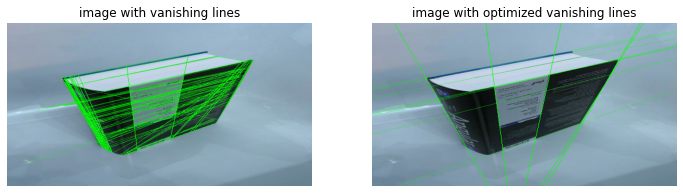

In [209]:
image = cv2.imread(imageName)
vanishing_points,lines = detect_vanishing_points(image)
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    cv2.line(imageWithEdgesOptimized,(x1,y1),(x2,y2),(0,255,0),1)

fig, axs = plt.subplots(1,2,figsize=(12,3))
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[0].imshow(imageWithEdges, aspect = 'auto')
axs[1].imshow(imageWithEdgesOptimized, aspect = "auto")
axs[0].set_title("image with vanishing lines")
axs[1].set_title("image with optimized vanishing lines")

#### --> variable vanishing_points, lines must be correct

# Tests get parallel vanishing points for x,y axis

In [75]:
#vanishing_points
#x = map(np.array, vanishing_points)
#x = np.array(list(x))

In [76]:
def intersect_lines2(line1, line2):
    # Estimate the equations of the lines
    #y = mx+b

    x1, y1, x2, y2 = line1
    if x2 - x1 == 0:
        # Line 1 is vertical
        m1 = float('inf')
        b1 = x1
    else:
        # Line 1 is not vertical
        m1 = (y2 - y1) / (x2 - x1)
        b1 = y1 - m1 * x1

    x1, y1, x2, y2 = line2
    if x2 - x1 == 0:
        # Line 2 is vertical
        m2 = float('inf')
        b2 = x1
    else:
        # Line 2 is not vertical
        m2 = (y2 - y1) / (x2 - x1)
        b2 = y1 - m2 * x1

    # Intersect the lines
    if m1 == m2:
        # Lines are parallel
        return None
    elif m1 == float('inf'):
        # Line 1 is vertical
        x = b1
        y = m2 * x + b2
    elif m2 == float('inf'):
        # Line 2 is vertical
        x = b2
        y = m1 * x + b1
    else:
        # Lines are not vertical
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1

    return x, y

In [77]:
def intersect_lines(line1, line2):
    # Estimate the equations of the lines
    #y = mx+b

    x1, y1, x2, y2 = line1
    if x2 - x1 == 0:
        # Line 1 is vertical
        m1 = float('inf')
        b1 = x1
    else:
        # Line 1 is not vertical
        m1 = (y2 - y1) / (x2 - x1)
        b1 = y1 - m1 * x1

    x1, y1, x2, y2 = line2
    if x2 - x1 == 0:
        # Line 2 is vertical
        m2 = float('inf')
        b2 = x1
    else:
        # Line 2 is not vertical
        m2 = (y2 - y1) / (x2 - x1)
        b2 = y1 - m2 * x1

    # Intersect the lines
    if m1 == m2:
        # Lines are parallel
        return None
    elif m1 == float('inf'):
        # Line 1 is vertical
        x = b1
        y = m2 * x + b2
    elif m2 == float('inf'):
        # Line 2 is vertical
        x = b2
        y = m1 * x + b1
    else:
        # Lines are not vertical
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1

    return x, y

In [78]:
#t = vanishing_points[0][0],vanishing_points[0][1], vanishing_points[1][0], vanishing_points[1][1]
#for i in range(10):
    #j=i
    #for j in range(10):
        #vanPoints1 = vanishing_points[i][j],vanishing_points[i][1], vanishing_points[i+1][0], vanishing_points[i+1][1]
        #vanPoints2 = vanishing_points[i][j],vanishing_points[i][j], vanishing_points[i][j], vanishing_points[i][j]
        #intersect_lines()

# detect points

## using vanishing points

In [155]:
print(vanishing_points[0])
print(vanishing_points[1])

(143273.99999999302, -66527.5410206864)
(1985.1664319677561, -649.9171595343174)


In [169]:
# Convert the vanishing_points list to a 3D numpy array
v = np.array(vanishing_points, dtype=np.float32)
v = np.hstack((v, np.zeros((v.shape[0], 1))))
v.shape
v[0]

array([143274.       , -66527.5390625,      0.       ])

In [181]:
X_axis = vanishing_points[0][0] - vanishing_points[1][0], vanishing_points[0][1] - vanishing_points[1][1]
Y_axis = vanishing_points[0][0] - vanishing_points[2][0], vanishing_points[0][1] - vanishing_points[2][1]
Z_axis = np.cross(X_axis, Y_axis)
origin = v[0]
origin

array([143274.       , -66527.5390625,      0.       ])

In [192]:
# Convert the 2D points to homogeneous coordinates
v = np.array(vanishing_points, dtype=np.float32)
v = np.hstack((v, np.zeros((v.shape[0], 1))))
# Define the projection matrix
projection_matrix = k_matrix.dot(np.hstack((r_vecs, t_vecs.T)))
projection_matrix.shape
# Invert the projection matrix
#projection_matrix_inv = np.linalg.inv(projection_matrix)
# Project the 2D points onto the 3D world coordinate system
#points_3d = v.dot(projection_matrix_inv.T)
#points_3d = points_2d_homogeneous.dot(projection_matrix.T)
# Normalize the 3D points
#points_3d = points_3d / points_3d[:, -1:]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2 and the array at index 1 has size 1

In [184]:
points_3d = cv2.projectPoints(v, r_vecs[1], t_vecs[1], k_matrix, None)[0]
# Convert the image plane coordinates to 3D world coordinates
#points_3d = points_3d.reshape(-1, 3)
print(points_3d.shape)
points_3d[0]

(78, 1, 2)


array([[-8802.7050736,  2409.8909429]])

In [178]:
points_3d = points_3d - origin
points_3d = np.dot(points_3d, np.vstack((X_axis, Y_axis)).T)

(78, 1, 2)
-8802.705073600204


ValueError: operands could not be broadcast together with shapes (78,1,2) (3,) 

(78, 1, 2)


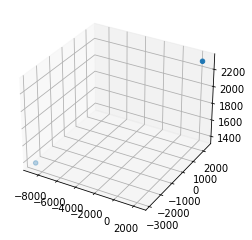

In [194]:
points_3d = cv2.projectPoints(v, r_vecs[1], t_vecs[1], k_matrix, None)[0]
print(points_3d.shape)
plt.interactive(True)
# Create a 3D scatter plot of the 3D world coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:][0], points_3d[:][1], points_3d[:][2])
plt.show()

In [204]:
print(points_3d.shape)
points_3d[0][0]

(78, 1, 2)


array([-8802.7050736,  2409.8909429])

## Using vanishing lines

In [117]:
x = np.array(lines, dtype=np.float32).reshape(-1, 2, 1)
x = np.concatenate((x, np.zeros((x.shape[0], 1, 1))), axis=1)
x.shape

(13, 3, 1)

(13, 1, 2)


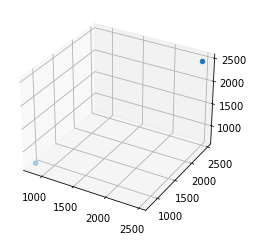

In [119]:
lines_3d = cv2.projectPoints(x, r_vecs[1], t_vecs[1], k_matrix, distortion)[0]
print(lines_3d.shape)
plt.interactive(True)
# Create a 3D scatter plot of the 3D world coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lines_3d[:][0], lines_3d[:][1], lines_3d[:][2])
plt.show()

In [230]:
print(r_vecs.shape)
print(t_vecs.shape)
print(k_matrix.shape)
a = np.stack((r_vecs, t_vecs))
print(a.shape)

(2, 3, 1)
(2, 3, 1)
(3, 3)
(2, 2, 3, 1)


In [233]:
projection_matrix = k_matrix.dot(np.stack((r_vecs, t_vecs)))
# Convert the lines to the correct format
x = np.array(lines, dtype=np.float32).reshape(-1, 2, 1)
x = np.concatenate((x, np.zeros((x.shape[0], 1, 1))), axis=1)

# Back-project the lines onto the 3D world coordinate system
print(projection_matrix.shape)
#projection_matrix = projection_matrix.T
print(projection_matrix.shape)
lines = lines.T
print(lines.shape)
lines_3d = projection_matrix.dot(lines)
print(lines_3d.shape)


(3, 2, 2, 1)
(3, 2, 2, 1)
(13, 1, 2)
(3, 2, 2, 13, 2)


array([[[[-1.18416388e+06, -5.37356530e+03],
         [-1.21732047e+06, -5.37356530e+03],
         [-1.35468348e+06, -5.29089497e+03],
         [ 1.70519599e+05, -1.38059289e+04],
         [-1.58204295e+06, -5.12555431e+03],
         [-2.07465512e+06, -1.07471303e+03],
         [-2.60042389e+06, -4.05084142e+03],
         [ 8.99964550e+05, -1.46326311e+04],
         [-1.49204649e+06, -4.13351160e+02],
         [-1.59625291e+06, -5.04288454e+03],
         [-2.08886509e+06, -1.15738329e+03],
         [-1.61519954e+06, -4.96021421e+03],
         [-1.88992556e+06, -4.79487355e+03]],

        [[-9.49130510e+05, -4.30701768e+03],
         [-9.75706164e+05, -4.30701768e+03],
         [-1.08580530e+06, -4.24075579e+03],
         [ 1.36674793e+05, -1.10657220e+04],
         [-1.26803836e+06, -4.10823202e+03],
         [-1.66287665e+06, -8.61403513e+02],
         [-2.08429060e+06, -3.24682862e+03],
         [ 7.21339188e+05, -1.17283400e+04],
         [-1.19590444e+06, -3.31309039e+02],
        

In [ ]:
# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lines_3d[:, 0], lines_3d[:, 1], lines_3d[:, 2])
plt.show()

# check parameters from calibration

In [114]:
print(r_vecs.shape)
print(t_vecs.shape)
print(k_matrix.shape)
print(r_vecs[0][0])
x = r_vecs[0]
print(x.shape)
for i in range(r_vecs.shape[0]):
    for j in range(r_vecs.shape[1]):
        a[i][j] = r_vecs[i][j][0]

print(a.shape)
for row in r_vecs:
  print (' '.join(map(str,row)))

#rotaion vector should be 3x1 not 3x2
#translation vector should be 3x1 not 3x2

(2, 3, 1)
(2, 3, 1)
(3, 3)
[-0.13872818]
(3, 1)


IndexError: invalid index to scalar variable.

# additional code chatGBT answered

In [ ]:
import numpy as np
import cv2
def detect_points(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect features in the image using SIFT
    #sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)

    # Match the features using FLANN
    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des, des, k=2)

    # Select the good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Extract the 2D points from the good matches
    points_2d = np.array([kp[m.queryIdx].pt for m in good_matches])

    return points_2d

def project_points(points_2d, camera_matrix, origin, X_axis, Y_axis):
    # Back-project the 2D points onto the image plane using the camera matrix
    points_3d = cv2.projectPoints(points_2d, np.zeros((3,1)), np.zeros((3,1)), camera_matrix, np.zeros((4,1)))[0]

    # Convert the image plane coordinates to 3D world coordinates
    points_3d = points_3d.reshape(-1, 3)
    points_3d = points_3d - origin
    points_3d = np.dot(points_3d, np.vstack((X_axis, Y_axis)).T)

    return points_3d

In [ ]:
# Construct the 3D world coordinate system using the vanishing points and camera matrix
# by intersecting pairs of lines that are parallel in the real world X and Y-Axis can
X_axis = vanishing_points[0][0] - vanishing_points[1][0], vanishing_points[0][1] - vanishing_points[1][1]
Y_axis = vanishing_points[0][0] - vanishing_points[2][0], vanishing_points[0][1] - vanishing_points[2][1]
Z_axis = np.cross(X_axis, Y_axis)
origin = vanishing_points[0]

image = cv2.imread(imageName)
undistorted_image = cv2.undistort(image, k_matrix, distortion)
# Project the 2D points in the image onto the 3D world coordinate system
points_2d = detect_points(undistorted_image)
#points_3d = project_points(points_2d, k_matrix, origin, X_axis, Y_axis)

In [ ]:
def project_points_to_3d(points_2d, projection_matrix):
    # Convert the 2D points to homogeneous coordinates
    points_2d_homogeneous = np.hstack((points_2d, np.zeros((points_2d.shape[0], 1))))
    # Invert the projection matrix
    projection_matrix_inv = np.linalg.inv(projection_matrix)
    # Project the 2D points onto the 3D world coordinate system
    points_3d = points_2d_homogeneous.dot(projection_matrix_inv.T)
    #points_3d = points_2d_homogeneous.dot(projection_matrix.T)
    # Normalize the 3D points
    #points_3d = points_3d / points_3d[:, -1:]

    return points_3d
print(points_2d.shape)
points_3d = project_points_to_3d(points_2d, k_matrix)
print(points_3d.shape)

(72, 2)
(72, 3)


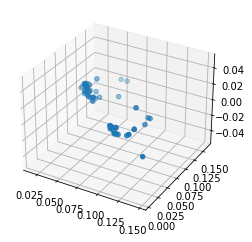

In [92]:
plt.interactive(True)
# Create a 3D scatter plot of the 3D world coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], np.abs(points_3d[:,2]))
plt.show()

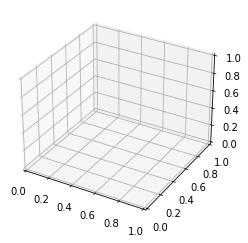

In [ ]:
x = []
for i in range(len(points_3d)):
    
    if points_3d[i][2] != 0:
        x.append(points_3d[i])

plt.interactive(True)
# Create a 3D scatter plot of the 3D world coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(x[:][0], x[:][1], x[:][2])
#plt.show()